<a href="https://colab.research.google.com/github/vivan-doshi/Insurance_claims/blob/main/12_EBM/DSO_530_EBM_final_with_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
# prompt: connect google colab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/ML Project/cleaned_data_final.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ML Project/cleaned_test_final.csv')

In [4]:
len(df)

37451

In [5]:
df['Loss_Cost'] = df['Loss_Cost'].fillna(0)
df['Historically_Adjusted_Loss_Cost'] = df['Historically_Adjusted_Loss_Cost'].fillna(0)

# STEP 4: Drop leakage and non-predictive columns
drop_cols = [
    'Unnamed: 0', 'ID',
    'Start_Date_Contract', 'Date_Last_Renewal', 'Date_Next_Renewal',
    'Date_Of_Birth', 'Date_Of_DL_Issuance',
    'Loss_Cost', 'Historically_Adjusted_Loss_Cost', 'Claim_Status',
    'Total_Cost_Claims_Current_Yr', 'Total_Number_Claims_Current_Yr',
    'Total_Number_Claims_Entire_Duration', 'Ratio_Claims_Total_Duration_Force'
]

In [6]:
df.isna().sum()

,0
Unnamed: 0,0
ID,0
Start_Date_Contract,0
Date_Last_Renewal,0
Date_Next_Renewal,0
Date_Of_Birth,0
Date_Of_DL_Issuance,0
Issurance_Broker_Agent_Channel,0
Years_Associates,0
Total_Policies_Entity,0


In [7]:
# prompt: change nan values in Energy_Source to 'N'

df['Energy_Source'] = df['Energy_Source'].fillna('N')


In [8]:
X_raw = df.drop(columns=drop_cols)
y_lc = df['Loss_Cost']
y_halc = df['Historically_Adjusted_Loss_Cost']
y_cs= df['Claim_Status']

In [9]:
X_encoded = pd.get_dummies(X_raw, drop_first=True)

In [10]:
pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 59.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 151.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 14.7 MB/s eta 0:00:00
   ━━

In [11]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.6 MB/s eta 0:00:00


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Create quantile bins
y_lc_quantiles = pd.qcut(y_lc, q=4, labels=False, duplicates='drop')
y_halc_quantiles = pd.qcut(y_halc, q=4, labels=False, duplicates='drop')

# Combine them into a single stratification label
combined_bins = y_lc_quantiles * 4 + y_halc_quantiles

# Train-test split using combined quantile bins
# X_train, X_test, y_lc_train, y_lc_test, y_halc_train, y_halc_test = train_test_split(
#     X_encoded, y_lc, y_halc,
#     test_size=0.2,
#     random_state=42,
#     stratify=combined_bins
# )

In [12]:
from sklearn.model_selection import KFold
from interpret.glassbox import ExplainableBoostingRegressor

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_scores = pd.DataFrame(index=X_encoded.columns)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_encoded, combined_bins)):
    X_fold_train = X_encoded.iloc[train_idx]
    y_fold = y_lc.iloc[train_idx]
    ebm = ExplainableBoostingRegressor(interactions=0, random_state=42, objective= 'tweedie_deviance:variance_power=1.5')
    ebm.fit(X_fold_train, y_fold)
    global_exp = ebm.explain_global()
    scores = pd.Series(global_exp.data()['scores'], index=X_encoded.columns, name=f"fold_{fold+1}")
    feature_scores = pd.concat([feature_scores, scores], axis=1)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


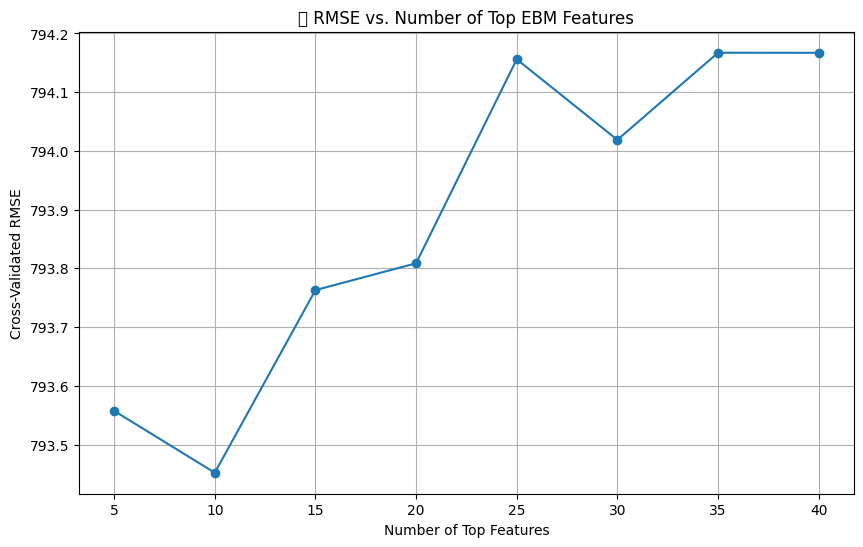

In [13]:
feature_scores['mean_importance'] = feature_scores.mean(axis=1)
sorted_scores = feature_scores['mean_importance'].sort_values(ascending=False)

# Evaluate RMSE for top-N features
rmse_list = []
feature_counts = list(range(5, 41, 5))
strat_kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for n in feature_counts:
    top_n_features = sorted_scores.head(n).index.tolist()
    ebm = ExplainableBoostingRegressor(interactions=0, random_state=42, objective= 'tweedie_deviance:variance_power=1.5')

    scores = cross_val_score(
        ebm,
        X_encoded[top_n_features],
        y_lc,
        scoring='neg_root_mean_squared_error',
        cv=strat_kf.split(X_encoded[top_n_features], combined_bins),
        n_jobs=-1
    )
    rmse_list.append(-scores.mean())

# Plot RMSE vs. number of top features
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, rmse_list, marker='o')
plt.title("📉 RMSE vs. Number of Top EBM Features")
plt.xlabel("Number of Top Features")
plt.ylabel("Cross-Validated RMSE")
plt.grid(True)
plt.show()

In [14]:
top_features = feature_scores['mean_importance'].sort_values(ascending=False).head(15).index.tolist()
print(top_features)

['Non_Payment_Termination', 'Non_Continuation_Insurance_Flag', 'Contract_Duration', 'Time_Since_Last_Renewal', 'Premium_Amt_Current_Yr', 'Half_Yearly_Payment_Method', 'Age_at_license', 'Market_Value_EOY19', 'Policies_Terminated_Non_Payment', 'Ratio_Premium_Car_Value', 'Motorbikes_Vans_Cars_Agricultural', 'Vehicle_Wt_Kg', 'Max_Policy_Simultaneous_Force', 'Cylinder_Capacity', 'Total_Policies_Entity']


In [15]:
!pip install optuna

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.model_selection import KFold

X_selected = X_encoded[top_features]

def objective_lc(trial):
    params = {
        'interactions': 15, 'max_bins': 512, 'max_leaves': 4, 'learning_rate': 0.006154562505539478, 'max_rounds': 363, 'min_samples_leaf': 20
    }
    # tweedie_variance_power_1 = trial.suggest_float('tweedie_variance_power_1', 1, 2)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_selected, combined_bins):
        X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_tr, y_val = y_lc.iloc[train_idx], y_lc.iloc[val_idx]

        model = ExplainableBoostingRegressor(objective=f'tweedie_deviance:variance_power = {1.3820967390033245}',**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(rmse)

    return np.mean(scores)

print("\n🔍 Tuning EBM for Loss Cost...")
study_lc = optuna.create_study(direction='minimize')
study_lc.optimize(objective_lc, n_trials=50, timeout=7200)
print(f"✅ Best RMSE for LC: {study_lc.best_value:.2f}")
print("🎯 Best Params for LC:", study_lc.best_params)
param_stored = study_lc.best_params

[I 2025-04-26 13:48:28,449] A new study created in memory with name: no-name-ca2c20ae-ad3a-4183-9165-764049e9bcfe



🔍 Tuning EBM for Loss Cost...


[I 2025-04-26 13:50:41,208] Trial 0 finished with value: 734.9165705179581 and parameters: {'interactions': 0, 'max_bins': 128, 'max_leaves': 2, 'learning_rate': 0.07643006674099996, 'max_rounds': 496, 'min_samples_leaf': 17, 'tweedie_variance_power_1': 1.2718966664490239}. Best is trial 0 with value: 734.9165705179581.
[I 2025-04-26 13:51:32,106] Trial 1 finished with value: 735.2850334107831 and parameters: {'interactions': 5, 'max_bins': 128, 'max_leaves': 2, 'learning_rate': 0.07507087162979306, 'max_rounds': 115, 'min_samples_leaf': 5, 'tweedie_variance_power_1': 1.3556848143493383}. Best is trial 0 with value: 734.9165705179581.
[I 2025-04-26 13:54:56,159] Trial 2 finished with value: 734.9516117917713 and parameters: {'interactions': 12, 'max_bins': 256, 'max_leaves': 6, 'learning_rate': 0.043773715348564654, 'max_rounds': 259, 'min_samples_leaf': 18, 'tweedie_variance_power_1': 1.4746418997608426}. Best is trial 0 with value: 734.9165705179581.
[I 2025-04-26 13:56:35,639] Trial

✅ Best RMSE for LC: 734.56
🎯 Best Params for LC: {'interactions': 15, 'max_bins': 512, 'max_leaves': 4, 'learning_rate': 0.006154562505539478, 'max_rounds': 363, 'min_samples_leaf': 20, 'tweedie_variance_power_1': 1.3820967390033245}


In [14]:
import optuna
from sklearn.metrics import mean_squared_error
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.model_selection import KFold
X_test = test_df[top_features]
top_features=['Non_Payment_Termination', 'Non_Continuation_Insurance_Flag', 'Contract_Duration', 'Time_Since_Last_Renewal', 'Premium_Amt_Current_Yr', 'Half_Yearly_Payment_Method', 'Age_at_license', 'Market_Value_EOY19', 'Policies_Terminated_Non_Payment', 'Ratio_Premium_Car_Value', 'Motorbikes_Vans_Cars_Agricultural', 'Vehicle_Wt_Kg', 'Max_Policy_Simultaneous_Force', 'Cylinder_Capacity', 'Total_Policies_Entity']


params = {
        'interactions': 15, 'max_bins': 512, 'max_leaves': 4, 'learning_rate': 0.006154562505539478, 'max_rounds': 363, 'min_samples_leaf': 20
    }
X_selected = X_encoded[top_features]
model = ExplainableBoostingRegressor(objective=f'tweedie_deviance:variance_power = {1.3820967390033245}',**params)
model.fit(X_selected, y_lc)
preds_lc = model.predict(X_test)

In [ ]:
def objective_halc(trial):
    params = {
        'interactions': 14, 'max_bins': 128, 'max_leaves': 6, 'learning_rate': 0.006952236825806292, 'max_rounds': 122, 'min_samples_leaf': 5, 'tweedie_variance_power_1': 1.0200318144020375}

    # tweedie_variance_power_2 = trial.suggest_float('tweedie_variance_power_1', 1, 2)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_selected, combined_bins):
        X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_tr, y_val = y_halc.iloc[train_idx], y_halc.iloc[val_idx]
        model = ExplainableBoostingRegressor(objective=f'tweedie_deviance:variance_power = {1.0200318144020375}',**params)
        model = ExplainableBoostingRegressor(**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(rmse)

    return np.mean(scores)

print("\n🔍 Tuning EBM for HALC...")
study_halc = optuna.create_study(direction='minimize')
study_halc.optimize(objective_halc, n_trials=50, timeout=900)
print(f"✅ Best RMSE for HALC: {study_halc.best_value:.2f}")
print("🎯 Best Params for HALC:", study_halc.best_params)
param_stored2 = study_lc.best_params

[I 2025-04-26 12:59:14,746] A new study created in memory with name: no-name-b8d05f3f-1907-4964-ac19-fffcbbb5bae1



🔍 Tuning EBM for HALC...


[I 2025-04-26 13:02:10,639] Trial 0 finished with value: 1467.2831373060797 and parameters: {'interactions': 12, 'max_bins': 128, 'max_leaves': 3, 'learning_rate': 0.011428044191856604, 'max_rounds': 341, 'min_samples_leaf': 2, 'tweedie_variance_power_1': 1.6279228392819673}. Best is trial 0 with value: 1467.2831373060797.
[I 2025-04-26 13:03:09,229] Trial 1 finished with value: 1467.3538281464275 and parameters: {'interactions': 7, 'max_bins': 128, 'max_leaves': 3, 'learning_rate': 0.09908609152346293, 'max_rounds': 148, 'min_samples_leaf': 9, 'tweedie_variance_power_1': 1.0486968161165073}. Best is trial 0 with value: 1467.2831373060797.
[I 2025-04-26 13:03:59,897] Trial 2 finished with value: 1470.9998639026035 and parameters: {'interactions': 0, 'max_bins': 512, 'max_leaves': 6, 'learning_rate': 0.061322622929431164, 'max_rounds': 326, 'min_samples_leaf': 9, 'tweedie_variance_power_1': 1.0262043782728327}. Best is trial 0 with value: 1467.2831373060797.
[I 2025-04-26 13:05:04,251] 

✅ Best RMSE for HALC: 1467.14
🎯 Best Params for HALC: {'interactions': 14, 'max_bins': 128, 'max_leaves': 6, 'learning_rate': 0.006952236825806292, 'max_rounds': 122, 'min_samples_leaf': 5, 'tweedie_variance_power_1': 1.0200318144020375}


In [13]:
import optuna
from sklearn.metrics import mean_squared_error
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.model_selection import KFold
top_features=['Non_Payment_Termination', 'Non_Continuation_Insurance_Flag', 'Contract_Duration', 'Time_Since_Last_Renewal', 'Premium_Amt_Current_Yr', 'Half_Yearly_Payment_Method', 'Age_at_license', 'Market_Value_EOY19', 'Policies_Terminated_Non_Payment', 'Ratio_Premium_Car_Value', 'Motorbikes_Vans_Cars_Agricultural', 'Vehicle_Wt_Kg', 'Max_Policy_Simultaneous_Force', 'Cylinder_Capacity', 'Total_Policies_Entity']
X_test = test_df[top_features]
params = {
        'interactions': 15, 'max_bins': 512, 'max_leaves': 4, 'learning_rate': 0.006154562505539478, 'max_rounds': 363, 'min_samples_leaf': 20}
X_selected = X_encoded[top_features]
model1 = ExplainableBoostingRegressor(objective=f'tweedie_deviance:variance_power = {1.0200318144020375}',**params)
model1.fit(X_selected, y_halc)
preds_halc = model1.predict(X_test)

In [36]:
# prompt: STORE HALC PREDICTIONS TO CSV

import pandas as pd
# Create a DataFrame for predictions
predictions_df = pd.DataFrame({'LC_Prediction': preds_lc, 'HALC_Prediction': preds_halc})

# Save predictions to a CSV file in Google Drive
predictions_df.to_csv('/content/drive/MyDrive/ML Project/lc_halc_predictions.csv', index=False)


In [30]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.metrics import mean_squared_error
import numpy as np

# # Step 1: Train the final model on full training data (already done if model exists)
# final_model_lc = ExplainableBoostingRegressor(
#     interactions=14,
#     max_bins=128,
#     max_leaves=6,
#     learning_rate=0.006952236825806292,
#     max_rounds=122,
#     min_samples_leaf=5
# )
# final_model_lc.fit(X_encoded[top_features], y_lc)

# Step 2: Explain globally (what features matter most + how they influence predictions)
global_exp = model.explain_global()

print("📊 Global Feature Importances:")
for feature, score in zip(global_exp.data()['names'], global_exp.data()['scores']):
    print(f"{feature}: {score:.4f}")

# Launch interactive visual explanation dashboard
show(global_exp)

📊 Global Feature Importances:
Non_Payment_Termination: 0.3192
Non_Continuation_Insurance_Flag: 0.2903
Contract_Duration: 0.3468
Time_Since_Last_Renewal: 0.2863
Premium_Amt_Current_Yr: 0.1700
Half_Yearly_Payment_Method: 0.1551
Age_at_license: 0.1505
Market_Value_EOY19: 0.1095
Policies_Terminated_Non_Payment: 0.1924
Ratio_Premium_Car_Value: 0.0714
Motorbikes_Vans_Cars_Agricultural: 0.1005
Vehicle_Wt_Kg: 0.1064
Max_Policy_Simultaneous_Force: 0.0456
Cylinder_Capacity: 0.0735
Total_Policies_Entity: 0.0654
Non_Payment_Termination & Contract_Duration: 0.0800
Non_Payment_Termination & Premium_Amt_Current_Yr: 0.0566
Non_Payment_Termination & Ratio_Premium_Car_Value: 0.0593
Non_Payment_Termination & Total_Policies_Entity: 0.0619
Non_Continuation_Insurance_Flag & Contract_Duration: 0.0315
Contract_Duration & Time_Since_Last_Renewal: 0.0837
Contract_Duration & Premium_Amt_Current_Yr: 0.0946
Contract_Duration & Half_Yearly_Payment_Method: 0.0390
Contract_Duration & Policies_Terminated_Non_Payment: 

In [31]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Train the final model on full training data for HALC
# final_model_halc = ExplainableBoostingRegressor(
#     interactions=15,
#     max_bins=512,
#     max_leaves=4,
#     learning_rate=0.006154562505539478,
#     max_rounds=363,
#     min_samples_leaf=20
# )
# final_model_halc.fit(X_encoded[top_features], y_halc)

# Step 2: Explain globally
global_exp_halc = model1.explain_global()

print("📊 Global Feature Importances for HALC:")
for feature, score in zip(global_exp_halc.data()['names'], global_exp_halc.data()['scores']):
    print(f"{feature}: {score:.4f}")

# Launch interactive visual explanation dashboard
show(global_exp_halc)

📊 Global Feature Importances for HALC:
Non_Payment_Termination: 0.1249
Non_Continuation_Insurance_Flag: 0.1925
Contract_Duration: 0.2502
Time_Since_Last_Renewal: 0.1910
Premium_Amt_Current_Yr: 0.1285
Half_Yearly_Payment_Method: 0.1354
Age_at_license: 0.1046
Market_Value_EOY19: 0.0835
Policies_Terminated_Non_Payment: 0.1246
Ratio_Premium_Car_Value: 0.0461
Motorbikes_Vans_Cars_Agricultural: 0.0757
Vehicle_Wt_Kg: 0.0871
Max_Policy_Simultaneous_Force: 0.0345
Cylinder_Capacity: 0.0854
Total_Policies_Entity: 0.0610
Non_Payment_Termination & Contract_Duration: 0.1590
Non_Continuation_Insurance_Flag & Contract_Duration: 0.0873
Contract_Duration & Time_Since_Last_Renewal: 0.0921
Contract_Duration & Premium_Amt_Current_Yr: 0.1276
Contract_Duration & Half_Yearly_Payment_Method: 0.0624
Contract_Duration & Age_at_license: 0.0579
Contract_Duration & Market_Value_EOY19: 0.0654
Contract_Duration & Policies_Terminated_Non_Payment: 0.1564
Contract_Duration & Ratio_Premium_Car_Value: 0.0970
Contract_Dura

In [ ]:
df[df['Contract_Duration'] == df['Contract_Duration'].max()]

,Unnamed: 0,ID,Start_Date_Contract,Date_Last_Renewal,Date_Next_Renewal,Date_Of_Birth,Date_Of_DL_Issuance,Issurance_Broker_Agent_Channel,Years_Associates,Total_Policies_Entity,...,Customer_Loyalty,New_Bhp_Risk,Days_Driving_At_Start_Date,Age_at_license,Contract_Duration,Age_at_contract,Car_Age_Contract,Car_Age_Contract_Cat,Young_Driver,Young_Bhp_Risk
23800,23800,12566,1980-10-25,2018-10-25,2019-10-25,1951-09-25,1970-11-25,0,39,1,...,14.3,0,3622,7001,14244,29,11,Standard,0,0


In [ ]:

from sklearn.metrics import mean_tweedie_deviance

tweedie_final_lc = param_stored.pop('tweedie_variance_power_1')



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
tweedie_scores = []
for train_idx, val_idx in skf.split(X_selected, combined_bins):
  X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
  y_tr, y_val = y_lc.iloc[train_idx], y_lc.iloc[val_idx]

  model = ExplainableBoostingRegressor(objective=f'tweedie_deviance:variance_power = {tweedie_final_lc}',**param_stored)
  model.fit(X_tr, y_tr)
  preds = model.predict(X_val)
  rmse = np.sqrt(mean_squared_error(y_val, preds))
  tweedie_dev = mean_tweedie_deviance(y_val, preds, power=tweedie_final_lc)
  rmse_scores.append(rmse)
  tweedie_scores.append(tweedie_dev)

print(f"RMSE: {np.mean(rmse_scores):.2f}")
print(f"Tweedie Deviance: {np.mean(tweedie_scores):.2f}")

RMSE: 734.95
Tweedie Deviance: 64.02


In [ ]:
tweedie_final_lc = param_stored['tweedie_variance_power_1']
param_stored.pop('tweedie_variance_power_1')

{'interactions': 6,
 'max_bins': 512,
 'max_leaves': 3,
 'learning_rate': 0.007429403148954192,
 'max_rounds': 274,
 'min_samples_leaf': 12,
 'tweedie_variance_power_1': 1.38659404449943}

In [ ]:
param_stored = {'interactions': 6,
 'max_bins': 512,
 'max_leaves': 3,
 'learning_rate': 0.007429403148954192,
 'max_rounds': 274,
 'min_samples_leaf': 12,
 'tweedie_variance_power_1': 1.38659404449943}

In [16]:
import optuna
from sklearn.metrics import roc_auc_score
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
top_features=['Non_Payment_Termination', 'Non_Continuation_Insurance_Flag', 'Contract_Duration', 'Time_Since_Last_Renewal', 'Premium_Amt_Current_Yr', 'Half_Yearly_Payment_Method', 'Age_at_license', 'Market_Value_EOY19', 'Policies_Terminated_Non_Payment', 'Ratio_Premium_Car_Value', 'Motorbikes_Vans_Cars_Agricultural', 'Vehicle_Wt_Kg', 'Max_Policy_Simultaneous_Force', 'Cylinder_Capacity', 'Total_Policies_Entity']

X_selected = X_encoded[top_features]

def objective_cs(trial):
    params = {
        'interactions': trial.suggest_int('interactions', 0, 15),
        'max_bins': trial.suggest_categorical('max_bins', [128, 256, 512]),
        'max_leaves': trial.suggest_int('max_leaves', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_rounds': trial.suggest_int('max_rounds', 100, 500),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20),
        'random_state': 64
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_selected, y_cs):
        X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_tr, y_val = y_cs.iloc[train_idx], y_cs.iloc[val_idx]

        model_cs = ExplainableBoostingClassifier(**params)
        model_cs.fit(X_tr, y_tr)
        preds = model_cs.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        scores.append(auc)

    return np.mean(scores)

print("\n🔍 Tuning EBM for Claim Status...")
study_cs = optuna.create_study(direction='maximize')
study_cs.optimize(objective_cs, n_trials=50)
print(f"✅ Best AUC for Claim Status: {study_cs.best_value:.2f}")
print("🎯 Best Params for Claim Status:", study_cs.best_params)

[I 2025-05-07 20:10:03,025] A new study created in memory with name: no-name-cd67ba05-e0df-4348-8974-f94da043edef



🔍 Tuning EBM for Claim Status...


[I 2025-05-07 20:12:05,830] Trial 0 finished with value: 0.7884193401787678 and parameters: {'interactions': 1, 'max_bins': 256, 'max_leaves': 6, 'learning_rate': 0.007035358914460186, 'max_rounds': 384, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.7884193401787678.
[I 2025-05-07 20:13:47,589] Trial 1 finished with value: 0.7988178956216884 and parameters: {'interactions': 10, 'max_bins': 256, 'max_leaves': 4, 'learning_rate': 0.05386588530701967, 'max_rounds': 299, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.7988178956216884.
[I 2025-05-07 20:16:43,387] Trial 2 finished with value: 0.8008897592298923 and parameters: {'interactions': 13, 'max_bins': 256, 'max_leaves': 2, 'learning_rate': 0.014977588793417634, 'max_rounds': 343, 'min_samples_leaf': 15}. Best is trial 2 with value: 0.8008897592298923.
[I 2025-05-07 20:18:21,792] Trial 3 finished with value: 0.8005428775737592 and parameters: {'interactions': 14, 'max_bins': 256, 'max_leaves': 3, 'learning_rate': 0.04

✅ Best AUC for Claim Status: 0.80
🎯 Best Params for Claim Status: {'interactions': 15, 'max_bins': 128, 'max_leaves': 3, 'learning_rate': 0.03268079642421548, 'max_rounds': 460, 'min_samples_leaf': 9}


In [17]:
# prompt: I WANT TO PREDICT THE CLAIM STAUS ON TEST DATA USING THE BEST PARAMS

import pandas as pd
import optuna
from sklearn.metrics import roc_auc_score
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
# Assuming 'model' is your trained ExplainableBoostingRegressor for Claim Status
# and X_test is prepared as in your training code.
X_test = test_df[top_features]
best_params_cs = {'interactions': 15, 'max_bins': 128, 'max_leaves': 3, 'learning_rate': 0.03268079642421548, 'max_rounds': 460, 'min_samples_leaf': 9}
model_cs = ExplainableBoostingClassifier(**best_params_cs)
model_cs.fit(X_selected, y_cs)

preds_cs = model_cs.predict_proba(X_test)[:, 1]

# # Create a DataFrame for the predictions
# prediction_df = pd.DataFrame({'Claim_Status_Prediction': preds_cs})

# # Optionally, add other relevant columns from test_df if needed.
# # Example:
# # prediction_df['ID'] = test_df['ID']

# # Save the predictions to a CSV file
# prediction_df.to_csv('/content/drive/MyDrive/ML Project/claim_status_predictions_prob.csv', index=False)

# print("Claim status predictions saved to claim_status_predictions.csv")


In [18]:
# prompt: i want to include predicted test lc,halc,cs in new test dataset and export in csv

import pandas as pd
# Assuming preds_lc, preds_halc, and preds_cs are already calculated

# Create a DataFrame for predictions
predictions_df = pd.DataFrame({'LC_Prediction': preds_lc, 'HALC_Prediction': preds_halc, 'CS_Prediction': preds_cs})

# Concatenate with the original test dataset
test_df_with_preds = pd.concat([test_df, predictions_df], axis=1)

# Save the combined dataset to a CSV file in Google Drive
test_df_with_preds.to_csv('/content/drive/MyDrive/ML Project/test_with_predictions.csv', index=False)


In [19]:
test_df_with_preds.head()

,Unnamed: 0,Start_Date_Contract,Date_Last_Renewal,Date_Next_Renewal,Date_Of_Birth,Date_Of_DL_Issuance,Issurance_Broker_Agent_Channel,Years_Associates,Total_Policies_Entity,Max_Policy_Simultaneous_Force,...,Age_at_license,Contract_Duration,Age_at_contract,Car_Age_Contract,Car_Age_Contract_Cat,Young_Driver,Young_Bhp_Risk,LC_Prediction,HALC_Prediction,CS_Prediction
0,0,2017-06-23,2018-06-23,2019-06-23,1982-09-13,2011-02-03,0,2,2,2,...,10370,730,35,14,Standard,0,0,20.249125,70.606649,0.037144
1,1,2015-06-29,2016-06-29,2017-06-29,1946-07-07,1966-08-12,0,2,1,1,...,7341,731,69,16,Old,0,0,59.410426,124.504638,0.082291
2,2,2018-03-14,2018-03-14,2019-03-14,1957-12-26,1977-09-02,0,1,4,4,...,7190,365,61,15,Standard,0,0,58.643909,105.577152,0.221402
3,3,2014-10-16,2018-10-16,2019-10-16,1961-02-27,1980-10-29,1,5,1,1,...,7184,1826,53,16,Old,0,0,20.135114,33.050846,0.058119
4,4,2015-07-01,2017-07-01,2018-07-01,1986-07-03,2006-08-02,0,3,1,1,...,7335,1096,29,0,New,0,0,8.849447,26.593814,0.008326
